<a href="https://colab.research.google.com/github/kwulffert/ULMFiT_Sentiment_Analysis/blob/master/ULMFiT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook is divided in the following steps:

* Import libraries
* Data load
* Data exploration
* Text pre-processing
* Universal Language Model Fine Tunning (ULMFiT) application
 * General-domain LM pretraining
 * Target task LM fine-tuning
 * Target task classifier fine-tuning
* Analysis of results
* Conclusions

## Import libraries

In [97]:
import re                 # for data preprocessing using regular expressions
import string
import pandas as pd       # for handling dataframes
import collections        # used for count with Counter
import seaborn as sns     # for data visualization

In [98]:
from fastai.text import * # Framework with ULMFiT

## Data Load 

In [3]:
# Mount google drive with dataset
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [99]:
# Load dataset with tweets into a dataframe
#path = "data/Tweets.csv"
#path = "https://raw.githubusercontent.com/kwulffert/ULMFiT_Sentiment_Analysis/master/data/Tweets.csv?token=AI4NJNANKTNV52E4BUAC6JK7BQ7IW"
folder = os.path.join("/content/gdrive/My Drive/Colab Notebooks" , "model")
path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/data", "Tweets.csv")
df = pd.read_csv(path)

## Data Exploration

In [100]:
# First look at the first 5 rows of the dataset
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Our dataset has 15 columns and 14640 tweets.
<br> There are no null values in the columns text and airline_sentiment which are the columns we will be using for the ULMFit implementation for sentiment analysis. 

In [101]:
# Size of the dataset
df.shape

(14640, 15)

In [102]:
# List column names, sount of non null values and type of data in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Let's have a look at one tweet content.

In [180]:
# Let's define a reduced dataframe with only the columns with the text of the tweets and the label in airline_sentiment 
df_sent = df.copy()
df_sent = df_sent[["airline_sentiment","text"]]
df_sent = df_sent.rename(columns={"airline_sentiment":"label"})
df_sent.head(2)
                      

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.


In [104]:
# Overview of how many tweets are labelled in which categories
df_sent["label"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: label, dtype: int64

In [105]:
# Overview in percentage:
(100*df_sent["label"].value_counts()/len(df_sent)).round(2)

negative    62.69
neutral     21.17
positive    16.14
Name: label, dtype: float64

The vast majority of reviews is negative covering 62.29% of the available dataset. 
<br>Positive tweets are only 16.14% and neutral tweets 21.17% of the total tweets in our dataset.

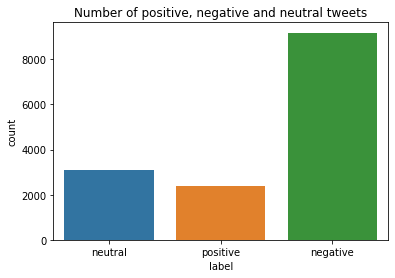

In [106]:
# Visualization of the  amount of positive, negative and neutral labelled tweets.
fig = sns.countplot(x = 'label', data = df_sent).set_title("Number of positive, negative and neutral tweets")

### Visualization of most frequent words

We will use WordCloud to show which words are the most frequent among the different categories of tweets.
<br>Stopwords are removed using the WordCloud inbuilt list of stopwords. They are removed as they don't add much meaning to a sentence and can be removed without impacting performance.

In [107]:
from wordcloud import WordCloud, STOPWORDS #, ImageColorGenerator
# Start with one review:
df_sent_positive = df_sent[df_sent["label"]=="positive"]
df_sent_negative = df_sent[df_sent["label"]=="negative"]
df_sent_neutral = df_sent[df_sent["label"]=="neutral"]
text_all = " ".join(text for text in df_sent.text)
text_positive = " ".join(text for text in df_sent_positive.text)
text_negative = " ".join(text for text in df_sent_negative.text)
text_neutral = " ".join(text for text in df_sent_neutral.text)

<function matplotlib.pyplot.show>

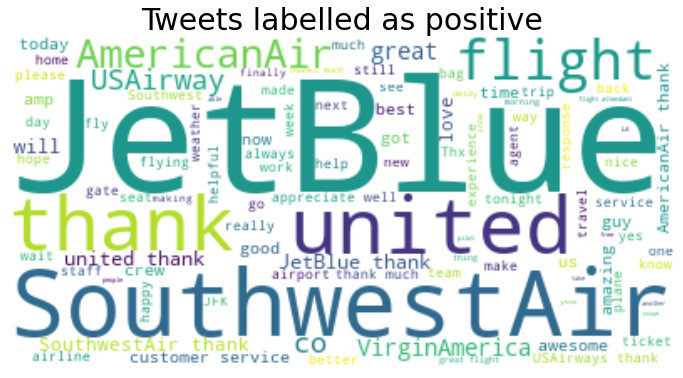

In [108]:
# Create and generate a word cloud image for positive labelled tweets:
wordcloud_positive = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_positive)
plt.figure(figsize  = (12,12))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Tweets labelled as positive',fontsize=30)
plt.axis('off')
plt.show

<function matplotlib.pyplot.show>

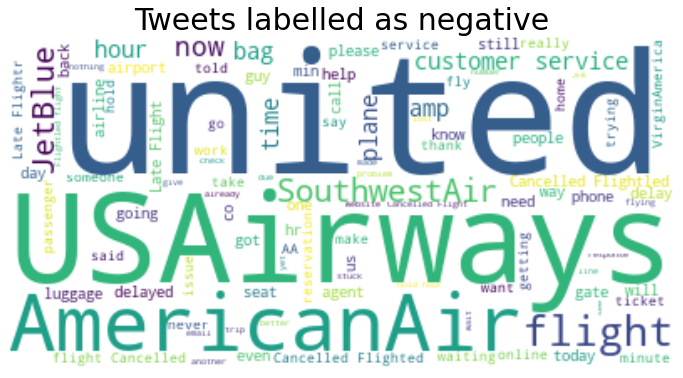

In [109]:
# Create and generate a word cloud image for negative labelled tweets:
wordcloud_negative = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_negative)
plt.figure(figsize  = (12,12))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Tweets labelled as negative',fontsize=30)
plt.axis('off')
plt.show

<function matplotlib.pyplot.show>

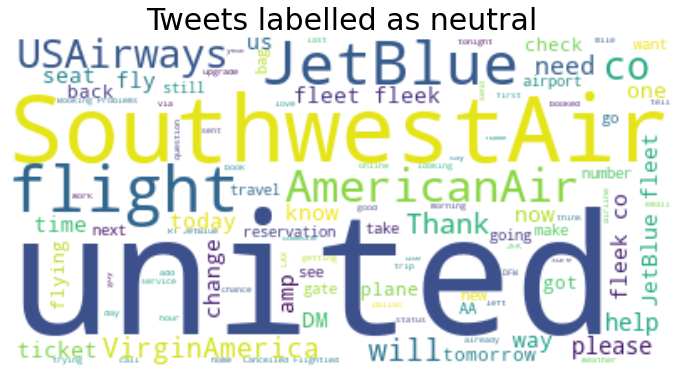

In [110]:
# Create and generate a word cloud image for positive labelled tweets:
wordcloud_neutral = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_neutral)
plt.figure(figsize  = (12,12))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Tweets labelled as neutral',fontsize=30)
plt.axis('off')
plt.show

In [125]:
wordcloud_all.words_

{'AA': 0.06484235574063058,
 'AmericanAir': 0.6781677572873289,
 'AmericanAir thank': 0.047888161808447356,
 'Cancelled Flight': 0.04878048780487805,
 'Cancelled Flighted': 0.06722189173111243,
 'Cancelled Flightled': 0.15110053539559787,
 'JFK': 0.05086258179654967,
 'JetBlue': 0.557703747769185,
 'Late Flight': 0.07406305770374777,
 'Late Flightr': 0.046995835812016655,
 'SouthwestAir': 0.5523497917906008,
 'SouthwestAir thank': 0.04640095181439619,
 'Thank': 0.1591314693634741,
 'USAirway': 0.734681737061273,
 'VirginAmerica': 0.1386079714455681,
 'agent': 0.07911957168352171,
 'airline': 0.11005353955978585,
 'airport': 0.1041046995835812,
 'already': 0.05383700178465199,
 'amp': 0.19958358120166567,
 'another': 0.0529446757882213,
 'back': 0.08030933967876264,
 'bag': 0.1635930993456276,
 'better': 0.05175490779298037,
 'call': 0.09220701963117192,
 'change': 0.0511600237953599,
 'check': 0.06395002974419989,
 'co': 0.2855443188578227,
 'customer service': 0.16924449732302202,
 'd

To check:
- Few high frequency tokens such as "","","" are frequently used in all the categorical classes 
- Removing these words along with stops words would not impact the performance.

## Text pre-processing

Let's have a look at how many labels are present in the dataset and how many tweets per label category the dataset has.

In [112]:
# For sentiment analysis of the tweet, we need the text only. Let's have a look at one example
pd.options.display.max_colwidth = 100
df["text"][df["tweet_id"] == 569987622484848640]

62    @VirginAmerica @ladygaga @carrieunderwood all are great , but I have to go with #CarrieUnderwood 😍👌
Name: text, dtype: object

Tweets contain emojis, handles, tags, spelling errors and informal grammar. 

For text pre-processing we will do the following:
* Convert text to lower case.
* Remove punctuation.
* Remove stopwords.

In [140]:
punctuation = string.punctuation
punctuation # Punctuation symbols that will be removed from the text.

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [195]:
def remove_punctuation(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

assert(remove_punctuation("!\"#$%&\'()*+,-./:HeLLo;<=>?@[\\]^_`{|}~") == "HeLLo") # Unit test to verify punctuation removal.

In [193]:
stopwords = set([remove_punctuation(x) for x in STOPWORDS])   # This is the in-built list of stopwords in Wordcloud, set to leave unique values.

In [192]:
def pre_processing(text):
  text = text.lower()   # Convert text to lower case.
  text = remove_punctuation(text) # Uses the already defined function to remove punctuation. 
  return " ".join([word for word in text.split(" ") if word not in stopwords])  # Remove stopwords and returns the cleaned text.
  
assert(pre_processing("@VirginAmerica What @dhepburn said.") == "virginamerica dhepburn said") # Unit test to verify lower case conversion, removal of puctuation and stopwords (@, V, A, What, @, .). 

In [189]:
df_sent["clean"] = df_sent.apply(lambda x: pre_processing(x["text"]), axis=1)
df_sent.head(5)

,label,text,clean
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,virginamerica plus added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,virginamerica today must mean need take another trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &...",virginamerica really aggressive blast obnoxious entertainment guests faces amp little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,virginamerica really big bad thing


## Training

In [196]:
df_sent = df_sent.drop(labels = "text", axis=1)
df_sent.head(3)

,label,clean
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercials experience tacky
2,neutral,virginamerica today must mean need take another trip


In [197]:
da_train = df_sent.sample(frac = 0.9, random_state= 23)
da_test = df_sent.drop(da_train.index)

In [198]:
da_summary = pd.DataFrame((100*df_sent["label"].value_counts()/len(df_sent)).round(2))
da_summary["train[%]"] = (100*da_train["label"].value_counts()/len(da_train)).round(2)
da_summary["test[%]"] = (100*da_test["label"].value_counts()/len(da_test)).round(2)
da_summary = da_summary.rename(columns = {"label" : "original[%]"})
da_summary

,original[%],train[%],test[%]
negative,62.69,62.88,61.00
neutral,21.17,21.01,22.61
positive,16.14,16.11,16.39


## Universal Language Model Fine Tunning (ULMFiT) application

In [13]:
# Text in the tweet is one line long. Some text contain emojis, tags and possible spellimg mistakes. 
# They contain informal phraising too. 
# So first fine-tuning will be done on a social media corpus rather on the wikitext one.

In [14]:
data_lm = TextLMDataBunch.from_df(train_df = da_train, valid_df = da_train, path = folder)
data_lm.save('data_lm.pkl')

In [78]:
bs = 48
data_lm = load_data(folder, 'data_lm.pkl', bs=bs)

In [79]:
data_lm.show_batch()

idx,text
0,cheese xxunk and xxunk of entertainment options . xxmaj time just flew by . xxbos @southwestair just announced non - stop flights to xxmaj dallas from xxmaj columbus . xxmaj well next time xxunk best you 'll have less time airport xxunk 😂 😂 xxbos @united xxup thank u ! xxmaj secured room for the night xxmaj thx to xxup very helpful customer service rep xxup n. xxmaj xxunk ..
1,"numbers auto rebooked flights to non connecting cities xxbos @united do n't see a xxunk cost to get on an early flight with seats . xxmaj no airline charges to conveniently get their passengers in early xxbos @southwestair xxmaj are there discounts every tuesday cause i m leaving fron xxmaj birmingham xxmaj airport to xxmaj san fran xxmaj next week in march sometime xxbos @jetblue i cheated on you ,"
2,"houston until tomorrow morning . pretty sure overflight xxmaj booking xxmaj problems and maintenance are n't our fault . xxbos @usairways i was completely ripped of by xxup us xxmaj airways today never fly this airline i am contacting my local news xxbos @southwestair it 's not disappointment , it 's a blatant disregard for your business select customers , it 's becoming a problem that 's pushing xxbos @jetblue"
3,"rebook , but wondering if there will be other issues getting out . xxbos @united xxmaj so excited i was put on an earlier flight to get home ! xxmaj woo xxmaj hoo ! # travel 🎉 🎉 🎉 xxbos @southwestair xxmaj twitter says i ca n't xxup dm someone unless they follow me . xxmaj can @southwestair follows my twitter ? thanks you . xxbos @americanair xxmaj somehow between"
4,the accounts is denied xxbos @southwestair xxmaj tough i can take . xxmaj zero meaningful assistance while stranded for 2 days is another matter . xxmaj looking for signs you care abt cust . xxbos @jetblue xxmaj flight i want to book was $ 320 one day ; went to purchase next day & & price xxunk to $ 737 . xxmaj xxunk on chance it may go down ?


In [84]:
# Number of words in the vocabulary data_lm
len(data_lm.vocab.itos)

6312

### General-domain LM pretraining

### Target task LM fine-tuning

### Target task classifier fine-tuning

## Analysis of results

## Conclusions

In [199]:
! git status

fatal: not a git repository (or any of the parent directories): .git
